# Use Pipeline

In [27]:
import importlib.util
import sys
import os

# Construct full path to your local ModelPipeline file (inside __init__.py)
file_path = "/Users/zoe_mac/PycharmProjects/dsi-capstone-spring-2025-TD-anti-money-laundering/Code/src/pipeline/__init__.py"

# Load the module from file
spec = importlib.util.spec_from_file_location("custom_pipeline", file_path)
custom_pipeline = importlib.util.module_from_spec(spec)
spec.loader.exec_module(custom_pipeline)

# Now use the ModelPipeline class from that module
ModelPipeline = custom_pipeline.ModelPipeline


# Load df

In [28]:
xgb_pipeline = ModelPipeline(dataset_path="/Users/zoe_mac/Desktop/EDA/subset_transactions2.csv")

xgb_pipeline.run_preprocessing()

xgb_pipeline.df

Running preprocessing pipeline...

Creating unique ids...

Normalizing currency...

Extracting time features...

Adding cyclical encoding to time feats...

Applying label encoding...

Label encoding applied to columns: ['day_of_week', 'from_bank', 'to_bank']

Applying one hot encoding...

/Users/zoe_mac/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/Users/zoe_mac/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


One hot encoding applied to columns: ['payment_type', 'received_currency', 'sent_currency']

Extracting graph features...

Using default weight columns: ['sent_amount', 'received_amount']

Graph features computed using: ['sent_amount', 'received_amount']

**Note**, previously graph-based features were calculated using only `sent_amount` as edge weight (only based on 
outgoing transactions). Now both sent and received amounts are included by default.

New feature columns added: degree_centrality_sent_amount, degree_centrality_received_amount, 
pagerank_sent_amount, pagerank_received_amount

Preprocessing completed successfully!

{
    'renamed': True,
    'duplicates_removed': True,
    'unique_ids_created': True,
    'currency_normalized': True,
    'time_features_extracted': True,
    'cyclical_encoded': True,
    'weekend_encoded': True,
    'label_encoded': True,
    'neighbor_context_computed': True,
    'normalized': False,
    'onehot_encoded': True
}

,from_bank,to_bank,received_amount,sent_amount,is_laundering,from_account_id,to_account_id,from_account_idx,to_account_idx,sent_amount_usd,...,payment_type_Bitcoin,payment_type_Cash,payment_type_Cheque,payment_type_Credit Card,payment_type_Reinvestment,payment_type_Wire,degree_centrality_sent_amount,pagerank_sent_amount,degree_centrality_received_amount,pagerank_received_amount
0,8,8,3697.340000,3697.340000,0,10_8000EBD30,10_8000EBD30,0,0,3.697340e+03,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000139,0.000050,0.000139,0.000050
1,109,0,0.010000,0.010000,0,3208_8000F4580,1_8000F5340,1,81239,1.000000e-02,...,0.0,0.0,1.0,0.0,0.0,0.0,0.000019,0.000001,0.000019,0.000001
2,10,10,2806.970000,2806.970000,0,12_8000F5030,12_8000F5030,2,2,2.806970e+03,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000195,0.000243,0.000195,0.000243
3,8,8,36682.970000,36682.970000,0,10_8000F5200,10_8000F5200,3,3,3.668297e+04,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000121,0.000008,0.000121,0.000008
4,0,0,6162.440000,6162.440000,0,1_8000F5AD0,1_8000F5AD0,4,4,6.162440e+03,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000177,0.000092,0.000177,0.000092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250896,4222,3797,0.000223,0.000223,0,152627_813D6AFF1,53744_814237D21,48362,48634,1.876695e-08,...,1.0,0.0,0.0,0.0,0.0,0.0,0.000046,0.000007,0.000046,0.000007
1250897,4672,4671,0.417737,0.417737,0,254565_8147A3EC1,254355_8147A3E21,48834,75038,3.515537e-05,...,1.0,0.0,0.0,0.0,0.0,0.0,0.000037,0.000003,0.000037,0.000003
1250898,12,4222,0.051436,0.051436,0,15_813D8E211,152627_8147AA0B1,48375,69359,4.328685e-06,...,1.0,0.0,0.0,0.0,0.0,0.0,0.000046,0.000030,0.000046,0.000030
1250899,12,4222,0.084692,0.084692,0,15_813D8E211,152627_8147AA0B1,48375,69359,7.127401e-06,...,1.0,0.0,0.0,0.0,0.0,0.0,0.000046,0.000030,0.000046,0.000030


# Engineering One Hop Features

In [29]:
# Keep only the necessary columns from df early on
df = xgb_pipeline.df[['from_account_id', 'to_account_id', 'sent_amount_usd', 'is_laundering']].copy()
df["TxID"] = df.index

# Prepare for forward join
forward_df = df[['TxID', 'from_account_id', 'sent_amount_usd']].rename(
    columns={'TxID': 'forward_TxID',
             'from_account_id': 'receiver',
             'sent_amount_usd': 'forward_amount'}
)

# Prepare for backward join
backward_df = df[['TxID', 'to_account_id', 'sent_amount_usd']].rename(
    columns={'TxID': 'backward_TxID',
             'to_account_id': 'sender',
             'sent_amount_usd': 'backward_amount'}
)

# Forward Merge
df_forward = df.merge(forward_df, how='left', left_on='to_account_id', right_on='receiver')
df_forward = df_forward[(df_forward['forward_TxID'].isna()) | (df_forward['TxID'] != df_forward['forward_TxID'])]

# Backward Merge
df_backward = df.merge(backward_df, how='left', left_on='from_account_id', right_on='sender')
df_backward = df_backward[(df_backward['backward_TxID'].isna()) | (df_backward['TxID'] != df_backward['backward_TxID'])]

# Aggregate Features
fwd_stats = df_forward.groupby('TxID')['forward_amount'].agg(['min', 'max', 'mean', 'std']).add_prefix('onehop_forward_')
bwd_stats = df_backward.groupby('TxID')['backward_amount'].agg(['min', 'max', 'mean', 'std']).add_prefix('onehop_backward_')

# Merge with original
df_final = df.set_index('TxID').join(fwd_stats).join(bwd_stats).reset_index()


In [30]:
X1 = xgb_pipeline.df.columns
X_remove = ['TxID', 'is_laundering','from_account_id',	'to_account_id','from_account_idx','to_account_idx']

X = [x for x in X1 if x not in X_remove]

y = 'is_laundering'

# Training the Model

In [31]:
X_train, X_val, X_test, y_train, y_val, y_test = xgb_pipeline.split_train_test_val(X,y)

Data split using random_stratified method.

In [33]:
from catboost import CatBoostClassifier, Pool

# Identify categorical features in X_train
cat_features = X_train.select_dtypes(include=['category']).columns.tolist()

# Create CatBoost Pools
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# Initialize and train the CatBoost model
model = CatBoostClassifier(
    iterations=1000,
    depth=8,
    learning_rate=0.05,
    loss_function='Logloss',
    eval_metric='F1',
    class_weights={0: 1, 1: 12},
    random_seed=42,
    silent=True
)

# Fit with early stopping
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, verbose=100)


0:	learn: 0.3904725	test: 0.3999377	best: 0.3999377 (0)	total: 238ms	remaining: 3m 58s
100:	learn: 0.6356234	test: 0.6209871	best: 0.6227151 (98)	total: 13.6s	remaining: 2m 1s
200:	learn: 0.6924757	test: 0.6477883	best: 0.6481752 (195)	total: 19.3s	remaining: 1m 16s
300:	learn: 0.7262457	test: 0.6637256	best: 0.6665791 (283)	total: 24.4s	remaining: 56.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6676751069
bestIteration = 327

Shrink model to first 328 iterations.


## Backward Selection

In [36]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score

def backward_feature_selection(X_train, y_train, X_val, y_val, cat_features=None, min_features=5, drop_threshold=0.01):
    """
    Performs backward feature elimination based on CatBoost's feature importance and validation F1 score.
    Stops when F1 score drops more than `drop_threshold` or only `min_features` remain.
    """
    current_features = X_train.columns.tolist()
    history = []

    # Initial full model
    best_model = CatBoostClassifier(
        iterations=300,
        depth=8,
        learning_rate=0.05,
        loss_function='Logloss',
        eval_metric='F1',
        class_weights={0: 1, 1: 12},
        random_seed=42,
        silent=True
    )
    best_model.fit(Pool(X_train, y_train, cat_features=cat_features),
                   eval_set=Pool(X_val, y_val, cat_features=cat_features),
                   early_stopping_rounds=30,
                   verbose=0)

    best_f1 = f1_score(y_val, best_model.predict(X_val))
    print(f"Initial F1 score (all features): {best_f1:.4f}")

    while len(current_features) > min_features:
        # Get feature importances from model
        importances = best_model.get_feature_importance(prettified=True)
        least_important = importances.sort_values("Importances").iloc[0]["Feature Id"]
        print(f"Trying to remove: {least_important}")

        reduced_features = [f for f in current_features if f != least_important]

        # Retrain with one feature removed
        model = CatBoostClassifier(
            iterations=300,
            depth=8,
            learning_rate=0.05,
            loss_function='Logloss',
            eval_metric='F1',
            class_weights={0: 1, 1: 12},
            random_seed=42,
            silent=True
        )
        model.fit(Pool(X_train[reduced_features], y_train, cat_features=[f for f in cat_features if f in reduced_features]),
                  eval_set=Pool(X_val[reduced_features], y_val, cat_features=[f for f in cat_features if f in reduced_features]),
                  early_stopping_rounds=30,
                  verbose=0)

        val_f1 = f1_score(y_val, model.predict(X_val[reduced_features]))
        delta = best_f1 - val_f1
        print(f"F1 after removing {least_important}: {val_f1:.4f} (Δ = {delta:.4f})")

        if delta > drop_threshold:
            print("Stopping: Performance dropped too much.")
            break
        else:
            current_features = reduced_features
            best_model = model
            best_f1 = val_f1
            history.append((least_important, val_f1))

    print("\n✅ Final selected features:", current_features)
    return best_model, current_features, history

In [37]:
cat_features = X_train.select_dtypes(include=['category']).columns.tolist()
model, selected_features, drop_history = backward_feature_selection(
    X_train, y_train, X_val, y_val, cat_features=cat_features, drop_threshold=0.01
)

Initial F1 score (all features): 0.3977
Trying to remove: payment_type_Wire
F1 after removing payment_type_Wire: 0.4002 (Δ = -0.0025)
Trying to remove: payment_type_Reinvestment
F1 after removing payment_type_Reinvestment: 0.4016 (Δ = -0.0014)
Trying to remove: sent_currency_Ruble
F1 after removing sent_currency_Ruble: 0.3990 (Δ = 0.0025)
Trying to remove: sent_currency_Yen
F1 after removing sent_currency_Yen: 0.4047 (Δ = -0.0057)
Trying to remove: sent_currency_Australian Dollar
F1 after removing sent_currency_Australian Dollar: 0.4057 (Δ = -0.0009)
Trying to remove: sent_currency_Brazil Real
F1 after removing sent_currency_Brazil Real: 0.4068 (Δ = -0.0011)
Trying to remove: received_currency_Yen
F1 after removing received_currency_Yen: 0.4164 (Δ = -0.0096)
Trying to remove: received_currency_Rupee
F1 after removing received_currency_Rupee: 0.4089 (Δ = 0.0076)
Trying to remove: sent_currency_Bitcoin
F1 after removing sent_currency_Bitcoin: 0.4097 (Δ = -0.0008)
Trying to remove: paymen

# Model Performance

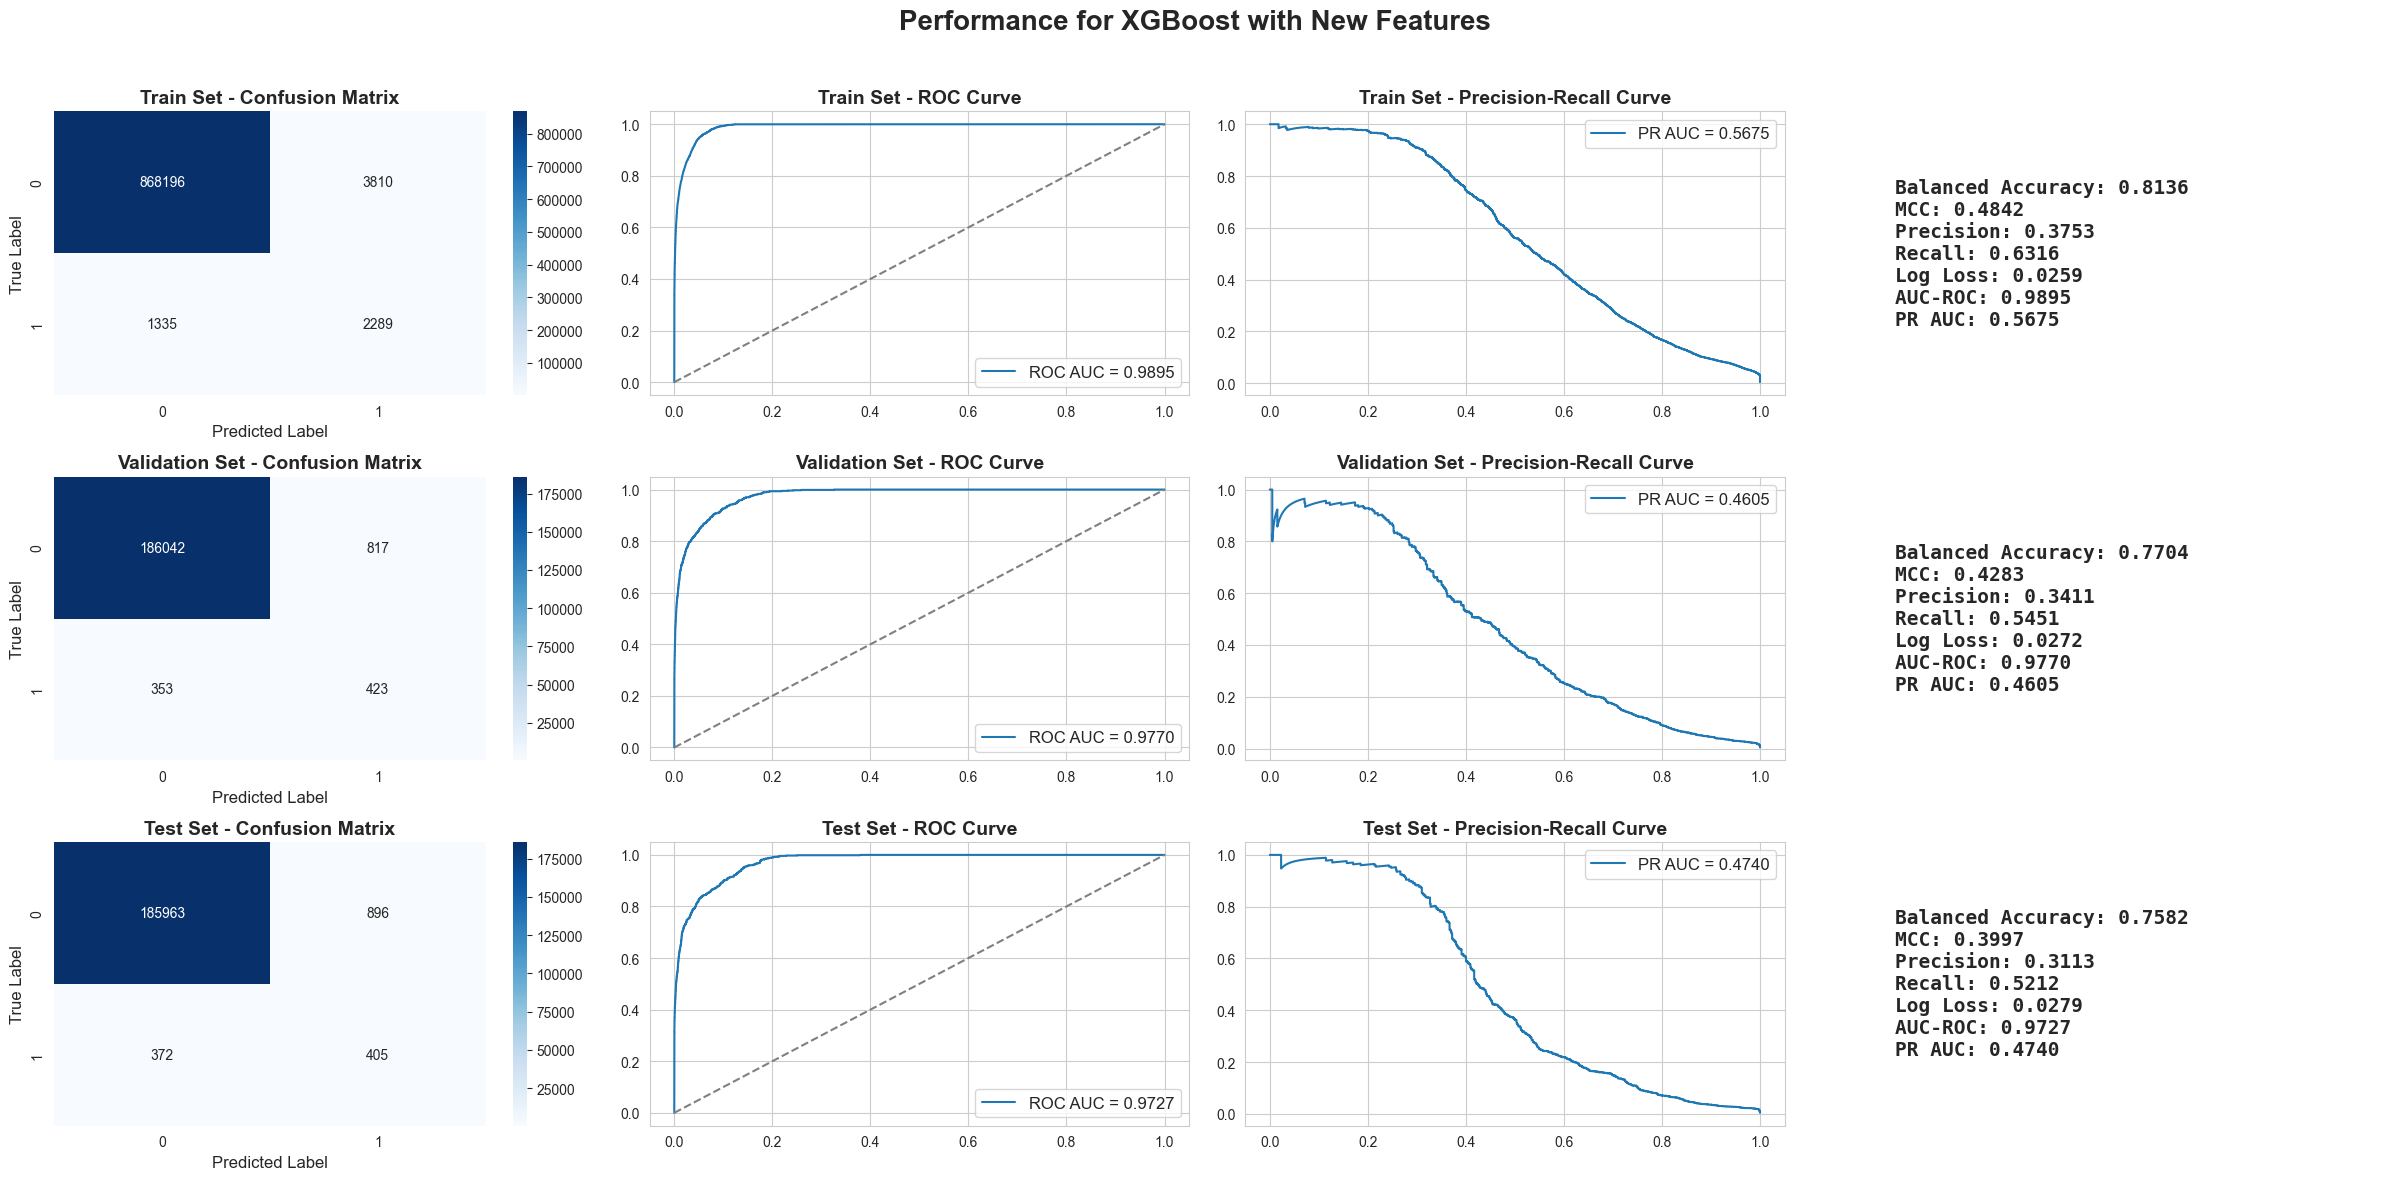

In [34]:
# Train predictions
train_proba = model.predict_proba(X_train)[:, 1]  # Get probability of class 1
train_pred = (train_proba > 0.5).astype(int)

# Validation predictions
val_proba = model.predict_proba(X_val)[:, 1]
val_pred = (val_proba > 0.5).astype(int)

# Test predictions
test_proba = model.predict_proba(X_test)[:, 1]
test_pred = (test_proba > 0.5).astype(int)


# Evaluate Model Performance
slide_title = "Performance for XGBoost with New Features"
metrics_summary = xgb_pipeline.result_metrics(
    slide_title,
    y_train, train_pred, train_proba,
    y_val, val_pred, val_proba,
    y_test, test_pred, test_proba,
    class_labels=["Licit", "Illicit"]
)

# Shap Value

/Users/zoe_mac/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


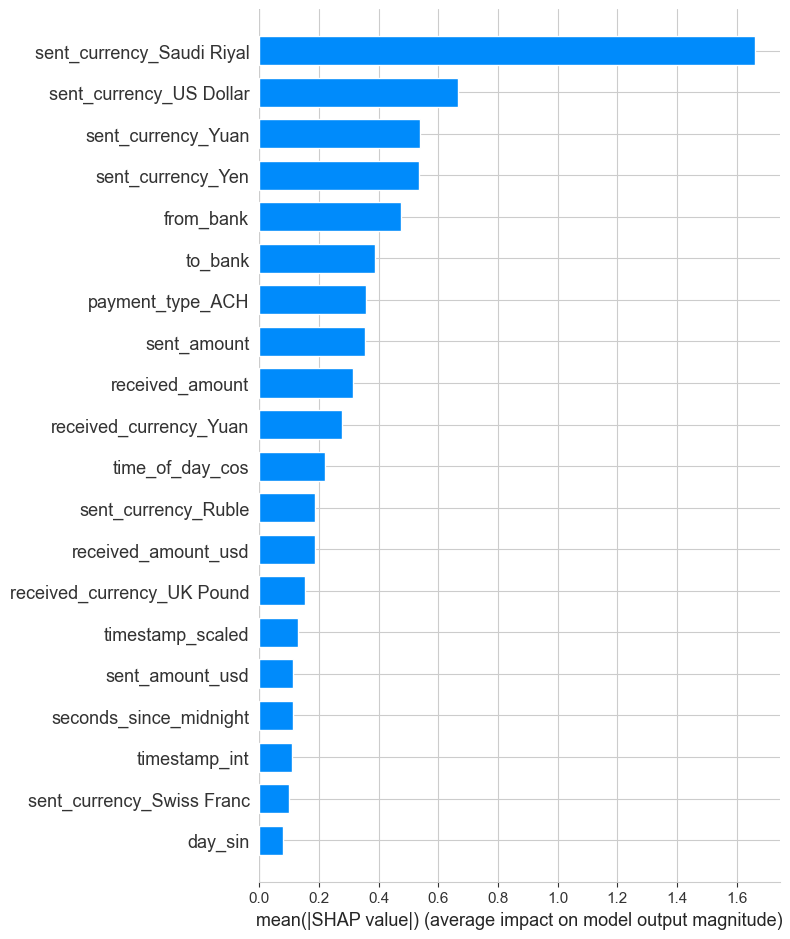

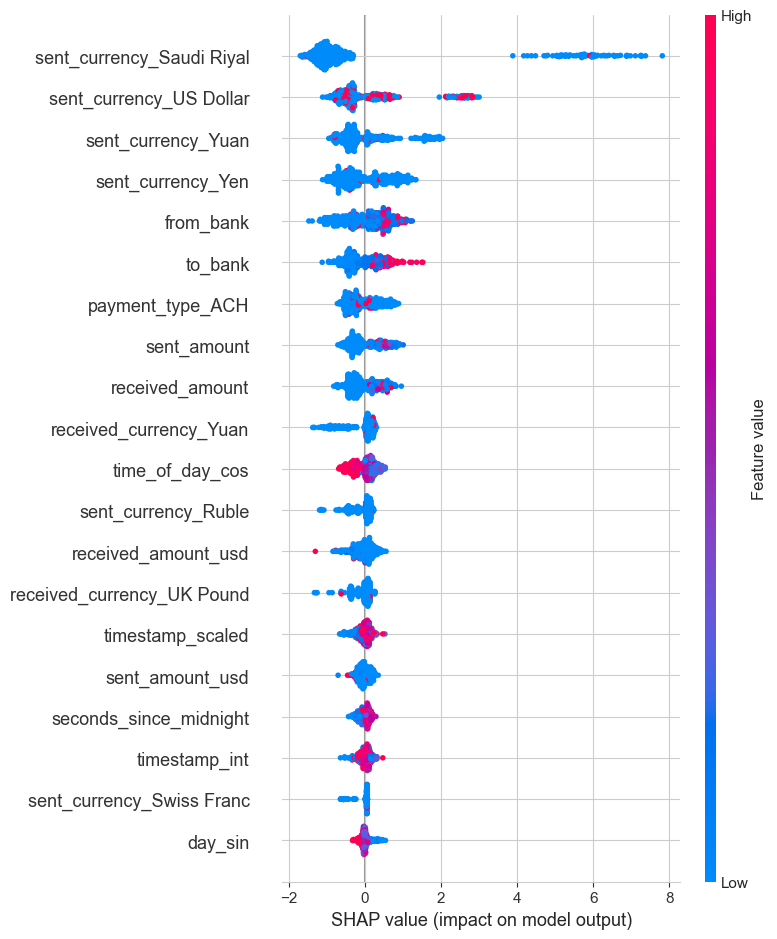

In [39]:
import shap

X_train = X_train.sample(n=500, random_state=42)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap_inter = explainer.shap_interaction_values(X_train)

# Summary Plot (Global Feature Importance)
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Optional: Summary dot plot (per-sample contribution)
shap.summary_plot(shap_values, X_train)